# Import packages to begin

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from joblib import parallel_backend
from sklearn.pipeline import Pipeline

# Dataset preparation

## "LAEI2013_MajorRoads_EmissionsbyLink_2013"
- Read the data
- Analyse missing value
- Drop unnecessary columns

In [ ]:
# read major roads emissions by link
MajorRoadByLinkData = pd.read_excel('../data/LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx', sheet_name='2013 LTS Rds')


According to the data analysis, these columns are sum of the other columns
- Car:	Sum of PetrolCar and DieselCar
- BusAndCoach: Sum of LtBus and Coach
- Lgv: Sum of PetrolLgv and DieselLgv
- Rigid: Sum of Rigid2Axle, Rigid3Axle, and Rigid4Axle
- Artic: Sum of Artic3Axle, Artic2Axle, and Artic4Axle

In [ ]:
# drop these columns because they are not used for modelling
MajorRoadByLinkData_cleaned = MajorRoadByLinkData.drop(['Car', 'BusAndCoach', 'Lgv', 'Rigid', 'Artic'], axis=1)
MajorRoadByLinkData_cleaned

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,...,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv,LtBus,Coach,ElectricCar,ElectricLgv
0,6253,4000000027908919,24,External,NonGLA,18898,50.761449,DFT,2013,CO2,...,0.241372,0.190560,8.761443,4.810774,3.755001e-02,1.735121,0.0,0.0,0.000000e+00,0.000000e+00
1,6253,4000000027947931,24,External,NonGLA,18895,28.592125,DFT,2013,CO2,...,0.000000,0.000000,0.015535,0.008576,0.000000e+00,0.000000,0.0,0.0,0.000000e+00,0.000000e+00
2,6253,4000000028013383,24,External,NonGLA,15816,5.101391,DFT,2013,CO2,...,0.027271,0.021509,0.939028,0.518684,4.055499e-03,0.184415,0.0,0.0,0.000000e+00,0.000000e+00
3,6253,4000000028025820,24,External,NonGLA,15816,3.757501,DFT,2013,CO2,...,0.020087,0.015843,0.691654,0.382044,2.987135e-03,0.135834,0.0,0.0,0.000000e+00,0.000000e+00
4,6253,4000000028029388,24,External,NonGLA,15816,1.624593,DFT,2013,CO2,...,0.008685,0.006850,0.299044,0.165180,1.291517e-03,0.058729,0.0,0.0,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366215,14525,4000000030981253,493,External,NonGLA,10910,68.300121,COPERT,2013,PM25_Tyre,...,0.000000,0.000000,0.000067,0.000040,3.705429e-07,0.000019,0.0,0.0,3.550464e-08,1.065791e-08
366216,14526,4000000031009965,494,External,NonGLA,10804,18.361482,COPERT,2013,PM25_Tyre,...,0.000000,0.000000,0.000017,0.000010,9.540952e-08,0.000005,0.0,0.0,9.141400e-09,2.744261e-09
366217,14540,4000000030121018,508,External,NonGLA,18275,150.698967,COPERT,2013,PM25_Tyre,...,0.000045,0.000022,0.001136,0.000674,6.210160e-06,0.000312,0.0,0.0,6.021130e-07,1.786226e-07
366218,14540,4000000030392332,508,External,NonGLA,18275,27.459057,COPERT,2013,PM25_Tyre,...,0.000008,0.000004,0.000207,0.000123,1.131561e-06,0.000057,0.0,0.0,1.097118e-07,3.254706e-08


In [ ]:
# transform the columns of emission of each vechnical type into separate rows as vechicle type and emission values
# melt emission columns
mrla_fix_columns = MajorRoadByLinkData_cleaned.columns[:11]
emission_columns = MajorRoadByLinkData_cleaned.columns[11:]

mrla_fix_columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit'],
      dtype='object')

In [ ]:

# melt the data into vechnicle type and emission value
MajorRoadByLinkData_cleaned = MajorRoadByLinkData_cleaned.melt(id_vars=mrla_fix_columns,
                       value_vars=emission_columns, var_name='VehicleType', value_name='Emission Value')


MajorRoadByLinkData_cleaned


,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,Emissions Unit,VehicleType,Emission Value
0,6253,4000000027908919,24,External,NonGLA,18898,50.761449,DFT,2013,CO2,tonnes/year,Motorcycle,1.582898e-01
1,6253,4000000027947931,24,External,NonGLA,18895,28.592125,DFT,2013,CO2,tonnes/year,Motorcycle,0.000000e+00
2,6253,4000000028013383,24,External,NonGLA,15816,5.101391,DFT,2013,CO2,tonnes/year,Motorcycle,1.697418e-02
3,6253,4000000028025820,24,External,NonGLA,15816,3.757501,DFT,2013,CO2,tonnes/year,Motorcycle,1.250257e-02
4,6253,4000000028029388,24,External,NonGLA,15816,1.624593,DFT,2013,CO2,tonnes/year,Motorcycle,5.405610e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5859515,14525,4000000030981253,493,External,NonGLA,10910,68.300121,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,1.065791e-08
5859516,14526,4000000031009965,494,External,NonGLA,10804,18.361482,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,2.744261e-09
5859517,14540,4000000030121018,508,External,NonGLA,18275,150.698967,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,1.786226e-07
5859518,14540,4000000030392332,508,External,NonGLA,18275,27.459057,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,3.254706e-08


## "LAEI2013_2013_AADT-VKM"

- check missing data and drop if necessary
- drop unnecessary columns
- transform the data with vehnicle type and corresponding AADT and VKM value

In [ ]:
# read road traffic data
RoadTrafficData = pd.read_excel('../data/LAEI2013_2013_AADT-VKM.xlsx', sheet_name='MajorGrid_AADTandVKM_2013')

#### Clean up missing data and drop unnecessary columns

In [ ]:
# check missing data in Road Traffic data
RoadTrafficData.isnull().sum()

RowID                   3
Year                    3
Toid                    3
GRID_ExactCut_ID        3
Location_ExactCut       3
BoroughName_ExactCut    3
TLRN                    3
MotorwayNumber          3
AADT Motorcycle         3
AADT Taxi               3
AADT Pcar               3
AADT Dcar               3
AADT PLgv               3
AADT DLgv               3
AADT LtBus              3
AADT Coach              3
AADT Rigid2Axle         3
AADT Rigid3Axle         3
AADT Rigid4Axle         3
AADT Artic3Axle         3
AADT Artic5Axle         3
AADT Artic6Axle         3
AADT ElectricCar        3
AADT ElectricLgv        3
AADT TOTAL              3
Speed (kph)             2
Length (m)              2
VKM_Motorcycle          3
VKM_Taxi                3
VKM_Pcar                3
VKM_Dcar                3
VKM_PLgv                3
VKM_DLgv                3
VKM_LtBus               3
VKM_Coach               3
VKM_Rigid2Axle          3
VKM_Rigid3Axle          3
VKM_Rigid4Axle          3
VKM_Artic3Ax

In [ ]:
# drop all missing rows
RoadTrafficData_cleaned = RoadTrafficData.dropna()

# after anlaysing the dataset, AADT TOTAL and VKM TOTAL are sum of the other columns
# drop the total column as they are not used in the modelling
RoadTrafficData_cleaned = RoadTrafficData_cleaned.drop(['AADT TOTAL', 'VKM_TOTAL'], axis=1)
RoadTrafficData_cleaned

,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,AADT Motorcycle,AADT Taxi,...,VKM_LtBus,VKM_Coach,VKM_Rigid2Axle,VKM_Rigid3Axle,VKM_Rigid4Axle,VKM_Artic3Axle,VKM_Artic5Axle,VKM_Artic6Axle,VKM_ElectricCar,VKM_ElectricLgv
0,1.0,2013.0,4.000000e+15,836.0,Outer,Hillingdon,Other,Other,88.301916,77.112580,...,470.278768,149.248696,293.680300,55.978941,39.030966,16.191367,10.970609,3.993946,4.335614,1.235289
1,2.0,2013.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,Other,88.301916,77.112580,...,309.432150,98.338925,193.503902,36.884134,25.717231,10.668379,7.228458,2.631583,2.856706,0.813924
2,3.0,2013.0,4.000000e+15,282.0,External,NonGLA,Other,Other,310.363572,100.322495,...,2216.046236,1657.075319,12950.212101,3011.364039,2861.551314,1710.809301,1966.897025,1647.110606,221.806380,47.635028
3,4.0,2013.0,4.000000e+15,873.0,Outer,Hillingdon,Other,Other,39.473081,144.548284,...,322.624763,118.008843,9777.985094,2051.227418,1024.275647,470.758531,815.631678,1959.389833,78.775616,15.287825
4,5.0,2013.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,Other,39.473081,144.548284,...,1096.887173,401.216526,33244.027352,6973.937855,3482.419671,1600.524988,2773.054115,6661.700602,267.828056,51.976850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87991,87992.0,2013.0,4.000000e+15,2781.0,Outer,Brent,Other,Other,77.456970,87.228788,...,0.000000,0.000000,1526.386160,140.588199,230.966327,120.504171,150.630213,110.462156,13.990264,2.624821
87992,87993.0,2013.0,4.000000e+15,2736.0,Outer,Brent,Other,Other,292.804370,341.246687,...,1702.409589,1228.784660,4861.898099,521.208506,741.093345,439.769677,602.647336,350.186965,44.184468,8.297322
87993,87994.0,2013.0,4.000000e+15,2021.0,Outer,Brent,Other,Other,106.396937,126.529671,...,0.000000,0.000000,1372.566897,133.258922,193.225437,99.944192,179.899545,86.618299,13.328744,2.493804
87994,87995.0,2013.0,4.000000e+15,1374.0,Outer,Barnet,Other,Other,28.939967,31.632418,...,11751.707498,0.000000,2587.404279,280.561910,374.082546,124.694182,311.735455,0.000000,16.124641,3.016591


In [ ]:
# transform the data into vehicle type, AADT, VKM
rtd_fix_columns = list(RoadTrafficData_cleaned.columns[:8]) + list(RoadTrafficData_cleaned.columns[24:26])
aadt_columns = [col for col in RoadTrafficData_cleaned.columns if col.startswith('AADT')]
vkm_columns = [col for col in RoadTrafficData_cleaned.columns if col.startswith('VKM')]


In [ ]:
# Melt AADT columns
df_aadt = RoadTrafficData_cleaned.melt(id_vars=rtd_fix_columns,
                  value_vars=aadt_columns, var_name='VehicleType', value_name='AADT')

df_aadt['VehicleType'] = df_aadt['VehicleType'].str.replace('AADT ', '')
df_aadt

,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,Speed (kph),Length (m),VehicleType,AADT
0,1.0,2013.0,4.000000e+15,836.0,Outer,Hillingdon,Other,Other,36.938200,5.472146,Motorcycle,88.301916
1,2.0,2013.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,Other,35.285178,3.605559,Motorcycle,88.301916
2,3.0,2013.0,4.000000e+15,282.0,External,NonGLA,Other,Other,49.065141,113.618491,Motorcycle,310.363572
3,4.0,2013.0,4.000000e+15,873.0,Outer,Hillingdon,Other,Other,49.173100,52.797356,Motorcycle,39.473081
4,5.0,2013.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,Other,49.173100,179.504952,Motorcycle,39.473081
...,...,...,...,...,...,...,...,...,...,...,...,...
1407931,87992.0,2013.0,4.000000e+15,2781.0,Outer,Brent,Other,Other,22.977362,28.867165,ElectricLgv,0.249117
1407932,87993.0,2013.0,4.000000e+15,2736.0,Outer,Brent,Other,Other,39.828245,23.410723,ElectricLgv,0.971025
1407933,87994.0,2013.0,4.000000e+15,2021.0,Outer,Brent,Other,Other,17.946339,19.153564,ElectricLgv,0.356714
1407934,87995.0,2013.0,4.000000e+15,1374.0,Outer,Barnet,Other,Other,33.043041,89.612688,ElectricLgv,0.092226


In [ ]:

# Melt VKM columns
df_vkm = RoadTrafficData_cleaned.melt(id_vars=rtd_fix_columns,
                  value_vars=vkm_columns, var_name='VehicleType', value_name='VKM')

df_vkm['VehicleType'] = df_vkm['VehicleType'].str.replace('VKM_','')
df_vkm

,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,Speed (kph),Length (m),VehicleType,VKM
0,1.0,2013.0,4.000000e+15,836.0,Outer,Hillingdon,Other,Other,36.938200,5.472146,Motorcycle,176.368343
1,2.0,2013.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,Other,35.285178,3.605559,Motorcycle,116.207872
2,3.0,2013.0,4.000000e+15,282.0,External,NonGLA,Other,Other,49.065141,113.618491,Motorcycle,12871.009867
3,4.0,2013.0,4.000000e+15,873.0,Outer,Hillingdon,Other,Other,49.173100,52.797356,Motorcycle,760.687130
4,5.0,2013.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,Other,49.173100,179.504952,Motorcycle,2586.248957
...,...,...,...,...,...,...,...,...,...,...,...,...
1407931,87992.0,2013.0,4.000000e+15,2781.0,Outer,Brent,Other,Other,22.977362,28.867165,ElectricLgv,2.624821
1407932,87993.0,2013.0,4.000000e+15,2736.0,Outer,Brent,Other,Other,39.828245,23.410723,ElectricLgv,8.297322
1407933,87994.0,2013.0,4.000000e+15,2021.0,Outer,Brent,Other,Other,17.946339,19.153564,ElectricLgv,2.493804
1407934,87995.0,2013.0,4.000000e+15,1374.0,Outer,Barnet,Other,Other,33.043041,89.612688,ElectricLgv,3.016591


#### Combine df_aadt and dt_vkm

In [ ]:
# combine df_aadt and df_vkm

# combine the fix columns and vehicle type column as join columns
join_columns = list(rtd_fix_columns)
join_columns.append('VehicleType')


RoadTrafficData_cleaned = pd.merge(df_aadt, df_vkm, on=join_columns, how='inner')

RoadTrafficData_cleaned

,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,Speed (kph),Length (m),VehicleType,AADT,VKM
0,1.0,2013.0,4.000000e+15,836.0,Outer,Hillingdon,Other,Other,36.938200,5.472146,Motorcycle,88.301916,176.368343
1,2.0,2013.0,4.000000e+15,2217.0,Outer,Hillingdon,Other,Other,35.285178,3.605559,Motorcycle,88.301916,116.207872
2,3.0,2013.0,4.000000e+15,282.0,External,NonGLA,Other,Other,49.065141,113.618491,Motorcycle,310.363572,12871.009867
3,4.0,2013.0,4.000000e+15,873.0,Outer,Hillingdon,Other,Other,49.173100,52.797356,Motorcycle,39.473081,760.687130
4,5.0,2013.0,4.000000e+15,2930.0,Outer,Hillingdon,Other,Other,49.173100,179.504952,Motorcycle,39.473081,2586.248957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407931,87992.0,2013.0,4.000000e+15,2781.0,Outer,Brent,Other,Other,22.977362,28.867165,ElectricLgv,0.249117,2.624821
1407932,87993.0,2013.0,4.000000e+15,2736.0,Outer,Brent,Other,Other,39.828245,23.410723,ElectricLgv,0.971025,8.297322
1407933,87994.0,2013.0,4.000000e+15,2021.0,Outer,Brent,Other,Other,17.946339,19.153564,ElectricLgv,0.356714,2.493804
1407934,87995.0,2013.0,4.000000e+15,1374.0,Outer,Barnet,Other,Other,33.043041,89.612688,ElectricLgv,0.092226,3.016591


## Merge dataset- "MajorRoadTrafficData"

In [ ]:
# check the columns of the two datasets
print(RoadTrafficData_cleaned.columns)
print(MajorRoadByLinkData_cleaned.columns)

Index(['RowID', 'Year', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'TLRN', 'MotorwayNumber', 'Speed (kph)',
       'Length (m)', 'VehicleType', 'AADT', 'VKM'],
      dtype='object')
Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'VehicleType', 'Emission Value'],
      dtype='object')


In [ ]:
merge_columns = [ 'Year', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut', 'BoroughName_ExactCut','Length (m)', 'VehicleType']
MajorRoadTrafficData = pd.merge(MajorRoadByLinkData_cleaned, RoadTrafficData_cleaned, on=merge_columns, how='inner')

MajorRoadTrafficData

,GridId,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Lts,Length (m),Emissions,Year,Pollutant,Emissions Unit,VehicleType,Emission Value,RowID,TLRN,MotorwayNumber,Speed (kph),AADT,VKM
0,6253,4000000027908919,24,External,NonGLA,18898,50.761449,DFT,2013,CO2,tonnes/year,Motorcycle,1.582898e-01,57184.0,Other,Other,42.269546,91.075778,1687.445524
1,6253,4000000027947931,24,External,NonGLA,18895,28.592125,DFT,2013,CO2,tonnes/year,Motorcycle,0.000000e+00,83727.0,Other,Other,32.236053,0.000000,0.000000
2,6254,4000000027887254,25,External,NonGLA,15816,294.077765,DFT,2013,CO2,tonnes/year,Motorcycle,9.785034e-01,69680.0,Other,Other,35.051885,91.075778,9775.926853
3,6254,4000000027887284,25,External,NonGLA,16056,28.170162,DFT,2013,CO2,tonnes/year,Motorcycle,0.000000e+00,69683.0,Other,Other,31.195729,0.000000,0.000000
4,6254,4000000027887289,25,External,NonGLA,15815,199.607180,DFT,2013,CO2,tonnes/year,Motorcycle,1.065108e+00,81152.0,Other,Other,23.983710,120.866920,8805.955365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369115,14525,4000000030981253,493,External,NonGLA,10910,68.300121,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,1.065791e-08,86981.0,Other,Other,40.260860,0.039753,0.991015
3369116,14526,4000000031009965,494,External,NonGLA,10804,18.361482,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,2.744261e-09,76977.0,Other,Other,46.488063,0.039753,0.266420
3369117,14540,4000000030121018,508,External,NonGLA,18275,150.698967,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,1.786226e-07,51893.0,Other,Other,65.071915,0.365724,20.116713
3369118,14540,4000000030392332,508,External,NonGLA,18275,27.459057,COPERT,2013,PM25_Tyre,tonnes/year,ElectricLgv,3.254706e-08,51852.0,Other,Other,65.071915,0.365724,3.665493


## Merged dataset export

In [ ]:
CleanUpDataSetFile = '../data/MajorRoadTrafficData.csv'
MajorRoadTrafficData.to_csv(CleanUpDataSetFile)

# Data analysis

In [ ]:
# Define the file path and name
file_path = '../data/'
# merge_file_name = 'MajorRoadTrafficData.csv'
file_name = 'MajorRoadTrafficData.csv'

# file_path = '../data/MajorRoadTrafficData.csv'
df = pd.read_csv(file_path+file_name)

In [ ]:
# Filter to target- CO2
df = df[df['Pollutant'] == 'CO2']

# Step 1: Handling Missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Step 2: Removing Duplicates
df = df.drop_duplicates()

In [ ]:
# Step 3: Outlier Detection and Treatment using IQR method

numeric_df = df.select_dtypes(include=[np.number])

Q1 = numeric_df.quantile(0.25, numeric_only=True)
Q3 = numeric_df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Aligning DataFrame and IQR series for proper comparison
df_aligned, IQR_aligned = df.align(IQR, axis=1, copy=False)
Q1_aligned, _ = df.align(Q1, axis=1, copy=False)
Q3_aligned, _ = df.align(Q3, axis=1, copy=False)

df = df[~((df_aligned < (Q1_aligned - 1.5 * IQR_aligned)) | (df_aligned > (Q3_aligned + 1.5 * IQR_aligned))).any(axis=1)]

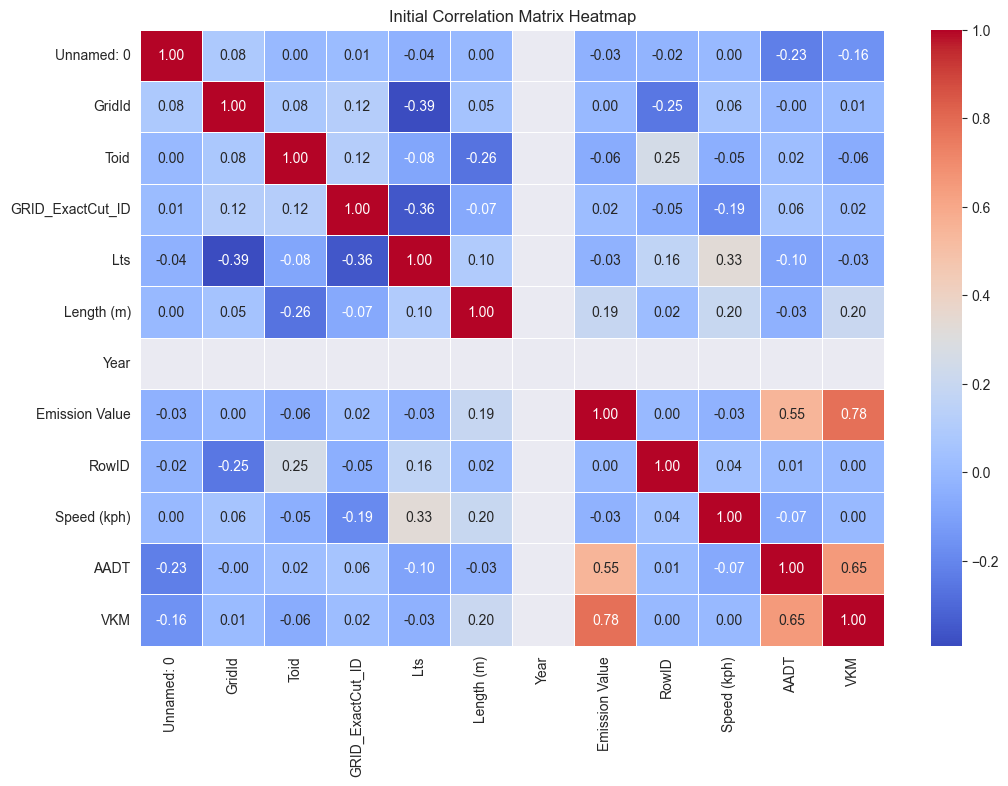

In [ ]:
# Filter numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Initial heatmap of the correlation matrix
initial_correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(initial_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Initial Correlation Matrix Heatmap')
plt.show()

In [ ]:
# Encode categorical variables
categorical_columns = ['Location_ExactCut', 'BoroughName_ExactCut', 'Emissions', 'Emissions Unit', 'VehicleType', 'Pollutant']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

# Calculate correlation matrix after encoding
encoded_correlation_matrix = df.corr()

# Correlation with the target variable
target_corr = encoded_correlation_matrix['Emission Value'].abs().sort_values(ascending=False)
print(target_corr)

# Select features with correlation greater than 0.05
selected_features = target_corr[target_corr > 0.05].index.tolist()
print(selected_features)
# # Add the target variable back to the selected features
selected_features.append('Emission Value')

df['Interaction_Length_Speed'] = df['Length (m)'] * df['Speed (kph)']
# df['Interaction_AADT_VKM'] = df['AADT'] * df['VKM']

# # Redefine features and preprocess again
# selected_features = selected_features + ['Interaction_Length_Speed', 'Interaction_AADT_VKM']
selected_features = selected_features + ['Interaction_Length_Speed']

# Plot final heatmap with Emission Value
final_correlation_matrix_with_target = df[selected_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix_with_target, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap with Target')
plt.show()

In [ ]:
# Final dataset with selected features, drop 'Emission Value' for training features
X = df[selected_features].drop(columns=['Emission Value'])
y = df['Emission Value']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for the scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Print the final selected features
print(X_scaled_df.head())

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Final heatmap of the correlation matrix without the target
final_correlation_matrix = X_scaled_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(final_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Final Correlation Matrix Heatmap of Selected Features')
plt.show()

In [ ]:
# The dataset is now ready for ML training
dataset_info = {
    "X_train_shape": X_train.shape,
    "X_test_shape": X_test.shape,
    "y_train_shape": y_train.shape,
    "y_test_shape": y_test.shape,
    "features": selected_features[:-1],  # exclude the target from features
    "target": 'Emission Value'
}

print(dataset_info)

# Machine learing algorithm

## Linear Regression

## Random Forest

In [ ]:
from skopt import BayesSearchCV

# Define the parameter space
param_space = {
    'n_estimators': (10, 100),
    'max_depth': (1, 20),
    'min_samples_split': (2, 20)
}

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=RandomForestRegressor(random_state=42),
                             search_spaces=param_space,
                             n_iter=50,
                             scoring='neg_mean_squared_error',
                             cv=5,
                             random_state=42)

# Fit Bayesian search
bayes_search.fit(X_train, y_train)

# Best parameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [6, 9, 44]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [19, 16, 58]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [4, 14, 81]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [16, 2, 100] before, using random point [5, 9, 27]
  warnings.warn(
/Users/shchan/anaconda3/envs/new_ml_env/lib/python3.10/site-packages/skopt/optimizer/optimize

Best Hyperparameters: OrderedDict([('max_depth', 20), ('min_samples_split', 2), ('n_estimators', 100)])


AttributeError: 'BayesSearchCV' object has no attribute 'space'

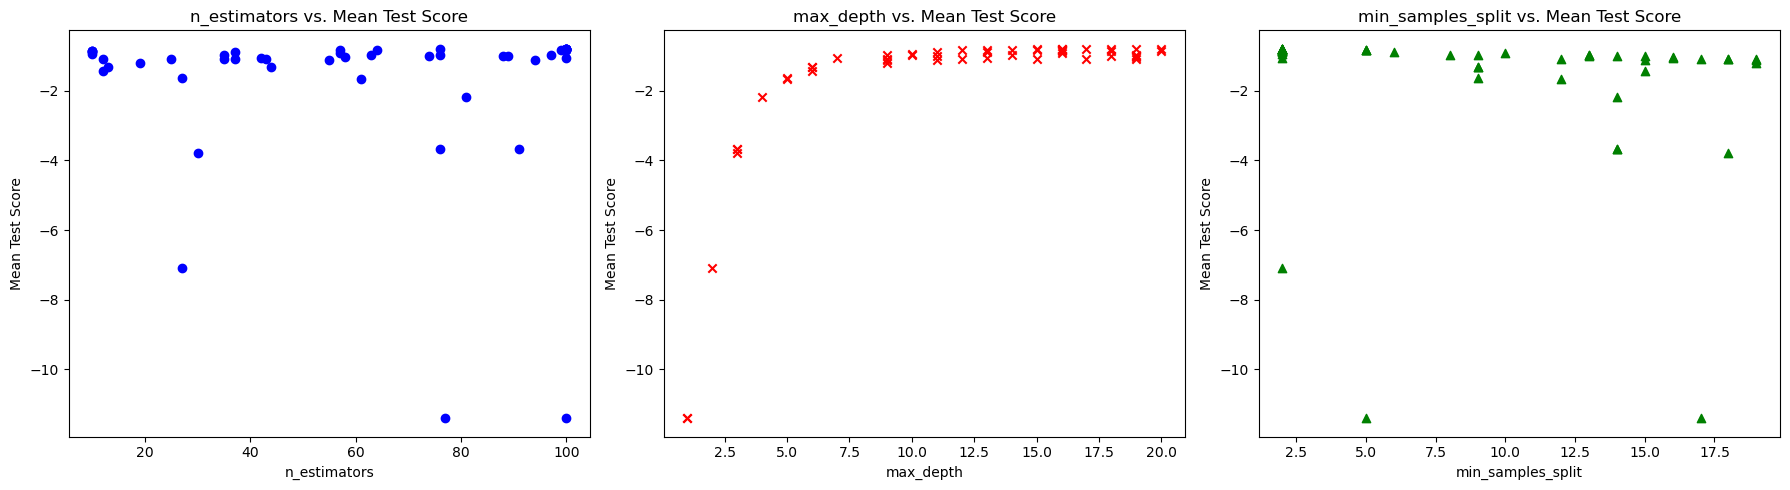

Best Hyperparameters: OrderedDict([('max_depth', 20), ('min_samples_split', 2), ('n_estimators', 100)])


In [ ]:
# Extract results from BayesSearchCV
results = pd.DataFrame(bayes_search.cv_results_)

# Create subplots to visualize hyperparameter effects
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot n_estimators vs. mean_test_score
axs[0].scatter(results['param_n_estimators'], results['mean_test_score'], c='blue', marker='o')
axs[0].set_xlabel('n_estimators')
axs[0].set_ylabel('Mean Test Score')
axs[0].set_title('n_estimators vs. Mean Test Score')

# Plot max_depth vs. mean_test_score
axs[1].scatter(results['param_max_depth'], results['mean_test_score'], c='red', marker='x')
axs[1].set_xlabel('max_depth')
axs[1].set_ylabel('Mean Test Score')
axs[1].set_title('max_depth vs. Mean Test Score')

# Plot min_samples_split vs. mean_test_score
axs[2].scatter(results['param_min_samples_split'], results['mean_test_score'], c='green', marker='^')
axs[2].set_xlabel('min_samples_split')
axs[2].set_ylabel('Mean Test Score')
axs[2].set_title('min_samples_split vs. Mean Test Score')

plt.tight_layout()
plt.show()

# Best hyperparameters from Bayesian Optimization
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

In [ ]:
# Extract the best hyperparameters
optimal_params = best_params

# Initialize the Random Forest model with optimal parameters
optimal_rf = RandomForestRegressor(
    n_estimators=optimal_params['n_estimators'],
    max_depth=optimal_params['max_depth'],
    min_samples_split=optimal_params['min_samples_split'],
    random_state=42
)

# Fit the model
optimal_rf.fit(X_train, y_train)

# Make predictions
y_pred_optimal = optimal_rf.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_optimal)
mse = mean_squared_error(y_test, y_pred_optimal)
r2 = r2_score(y_test, y_pred_optimal)

print("Performance with Optimal Hyperparameters:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Performance with Optimal Hyperparameters:
Mean Absolute Error (MAE): 0.09615430353533201
Mean Squared Error (MSE): 0.5638661624444575
R^2 Score: 0.9687481558378158


## Neural Network